# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Section 3: Recurrent Neural Networks


**Harvard University**<br/>
**Spring 2021**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, and Chris Tanner <br/>
**Authors**: Chris Gumb and Eleni Kaxiras


<hr style="height:2pt">

In [2]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

## Learning Objectives

By the end of this lab, you should understand:
- how to perform basic preprocessing on text data
- the layers used in `keras` to construct RNNs and its variants (GRU, LSTM)
- how the model's task (i.e., many-to-1, many-to-many) affects architecture choices

<a id="contents"></a>

## Notebook Contents
- [**IMDB Review Dataset**](#imdb)
- [**Preprocessing Text Data**](#prep)
    - [Tokenization](#token)
    - [Padding](#pad)
    - [Numerical Encoding](#encode)
- [**Movie Review Sentiment Analysis**](#models)
    - [Naive FFNN](#ffnn)
    - [Embedding Layer](#embed)
    - [1D CNN](#cnn)
    - [Vanilla RNN](#rnn)
    - [Vanishing/Exploding Gradients](#vanish)
    - [GRU](#gru)
    - [LSTM](#lstm)
    - [BiDirectional Layer](#bidir)
    - [Deep RNNs](#deep)
    - [TimeDistributed Layer](#timedis)
    - [RepeatVector Layer](#repeatvec)
    - [CNN + RNN](#cnnrnn)
- [**Heavy Metal Lyric Generator**](#metal)
    - [Creating Input/Target Pairs](#makepairs)
    - [LambdaCallback](#lambdacall)
- [**Arithmetic /w RNN**](#math)

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import BatchNormalization, Bidirectional, Dense, Embedding, GRU, LSTM, SimpleRNN,\
                                    Input, TimeDistributed, Dropout, RepeatVector
from tensorflow.keras.layers import Conv1D, Conv2D, Flatten, MaxPool1D, MaxPool2D, Lambda
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import tensorflow_datasets
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re, sys
# fix random seed for reproducibility
np.random.seed(109)

## Case Study: IMDB Review Classifier 
<img src='fig/manyto1.png' width='300px'>

Let's frame our discussion of RNNS around the example a text classifier. Specifically, We'll build and evaluate various models that all attempt to descriminate between positive and negative reviews through the Internet Movie Database (IMDB). The dataset is again made available to us through the tensorflow datasets API.

In [3]:
import tensorflow_datasets

In [4]:
(train, test), info = tensorflow_datasets.load('imdb_reviews', split=['train', 'test'], with_info=True)

The helpful `info` object provides details about the dataset.

In [5]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset.
    This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path='/home/10914655/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('text', 'label'),
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        'train': <SplitInfo num_examples=25000, num

We see that the dataset consists of text reviews and binary good/bad labels. Here are two examples:

In [6]:
labels = {0: 'bad', 1: 'good'}
seen = {'bad': False, 'good': False}
for review in train:
    label = review['label'].numpy()
    if not seen[labels[label]]:
        print(f"text:\n{review['text'].numpy().decode()}\n")
        print(f"label: {labels[label]}\n")
        seen[labels[label]] = True
    if all(val == True for val in seen.values()):
        break

text:
This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.

label: bad

text:
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the pl

Great! But unfortunately, computers can read! 📖--🤖❓

## Preprocessing Text Data <div id='prep'>

Computers have no built-in knowledge of language and cannot understand text data in any rich way that humans do -- at least not without some help! The first crucial step in natural language processing is to clean and preprocess your data so that your algorithms and models can make use of it.
    
We'll look at a few preprocess steps:
    - tokenization
    - padding
    - numerical encoding
        
Depending on your NLP task, you may want to take additional preprocessing steps which we will not cover here. These can include:
- converting all characters to lowercase
- treating each punctuation mark as a token (e.g., , . ! ? are each separate tokens)
- removing punctuation altogether
- separating each sentence with a unique symbol (e.g., <S> and </S>)
- removing words that are incredibly common (e.g., function words, (in)definite articles). These are referred to as 'stopwords').
- Lemmatizing (replacing words with their 'dictionary entry form')
- Stemming (removing grammatical morphemes)
    
Useful NLP Python libraries such as [NLTK](https://www.nltk.org/) and [spaCy](https://spacy.io/) provide built in methods for many of these preprocessing steps.

<div class='exercise' id='token'><b>Tokenization</b></div></br>

**Tokens** are the atomic units of meaning which our model will be working with. What should these units be? These could be characters, words, or even sentences. For our movie review classifier we will be working at the word level.

For this example we will process just a subset of the original dataset.

In [7]:
SAMPLE_SIZE = 10
subset = list(train.take(SAMPLE_SIZE))
subset[0]

{'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 'text': <tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">}

The TFDS format allows for the construction of efficient preprocessing pipelines. But for our own preprocessing example we will be primarily working with Python `list` objects. This gives us a chance to practice the Python **list comprehension** which is a powerful tool to have at your disposal. It will serve you well when processing arbitrary text which may not already be in a nice TFDS format (such as in the HW 😉).

We'll convert our data subset into X and y lists.

In [8]:
X = [x['text'].numpy().decode() for x in subset]
y = [x['label'].numpy() for x in subset]

In [9]:
print(f'X has {len(X)} reviews')
print(f'y has {len(y)} labels')

X has 10 reviews
y has 10 labels


In [10]:
N_CHARS = 20
print(f'First {N_CHARS} characters of all reviews:\n{[x[:20]+"..." for x in X]}\n')
print(f'All labels:\n{y}')

First 20 characters of all reviews:
['This was an absolute...', 'I have been known to...', 'Mann photographs the...', 'This is the kind of ...', 'As others have menti...', 'This is a film which...', 'Okay, you have:<br /...', 'The film is based on...', 'I really love the se...', "Sure, this one isn't..."]

All labels:
[0, 0, 0, 1, 1, 1, 0, 0, 0, 0]


Each observation in `X` is a review. A review is a `str` object which we can think of as a sequence of characters. This is indeed how Python treats strings as made clear by how we are printing 'slices' of each review in the code cell above.<br>

We'll see a bit later that you can in fact sucessfully train a neural network on text data at the character level.

But for the moment we will work at the word level, treating the word level. This means our observations should be organized as **sequences of words** rather than sequences of characters.

In [11]:
# list comprehensions again to the rescue!
X = [x.split() for x in X]
# The same thing can be accomplished with:
# list(map(str.split, X))
# but that is much harder to parse! O_o

Now let's look at the first 10 **tokens** in the first 2 reviews.

In [12]:
X[0][:10], X[1][:10]

(['This',
  'was',
  'an',
  'absolutely',
  'terrible',
  'movie.',
  "Don't",
  'be',
  'lured',
  'in'],
 ['I',
  'have',
  'been',
  'known',
  'to',
  'fall',
  'asleep',
  'during',
  'films,',
  'but'])

<div class='exercise' id='pad'><b>Padding</b></div></br>

Let's take a look at the lengths of the reviews in our subset.

In [13]:
[len(x) for x in X]

[116, 112, 132, 88, 81, 289, 557, 111, 223, 127]

If we were training our RNN one sentence at a time, it would be okay to have sentences of varying lengths. However, as with any neural network, it can be sometimes be advantageous to train inputs in batches. When doing so with RNNs, our input tensors need to be of the same length/dimensions.

Here are two examples of tokenized reviews padded to have a length of 5.
```
['I', 'loved', 'it', '<PAD>', '<PAD>']
['It', 'stinks', '<PAD>', '<PAD>', '<PAD>']
```
Now let's pad our own examples. Note that 'padding' in this context also means truncating sequences that are longer than our specified max length.

In [14]:
MAX_LEN = 500
PAD = '<PAD>'
# truncate
X = [x[:MAX_LEN] for x in X]
# pad
for x in X:
    while len(x) < MAX_LEN:
        x.append(PAD)

In [15]:
[len(x) for x in X]

[500, 500, 500, 500, 500, 500, 500, 500, 500, 500]

Now all reviews are of a uniform length!

<div class='exercise' id='encode'><b>Numerical Encoding</b></div></br>

If each review in our dataset is an observation, then the features of each observation are the tokens, in this case, words. But these words are still strings. Our machine learning methods require us to be able to multiple our features by weights. If we want to use these words as inputs for a neural network we'll have to convert them into some numerical representation.

One solution is to create a one-to-one mapping between unique words and integers.

If the five sentences below were our entire corpus, our conversion would look this:

1. i have books - [1, 4, 2]
2. interesting books are useful [11,2,9,8]
3. i have computers [1,4,3]
4. computers are interesting and useful [3,5,11,10,8]
5. books and computers are both valuable. [2,10,3,9,13,12]
6. bye bye [7,7]

I-1, books-2, computers-3, have-4, are-5, computers-6,bye-7, useful-8, are-9, and-10,interesting-11, valuable-12, both-13

To accomplish this we'll first need to know what all the unique words are in our dataset.

In [16]:
all_tokens = [word for review in X for word in review]

In [17]:
# sanity check
len(all_tokens), sum([len(x) for x in X])

(5000, 5000)

Casting our `list` of words into a `set` is a great way to get all the *unique* words in the data.

In [18]:
vocab = sorted(set(all_tokens))
print('Unique Words:', len(vocab))

Unique Words: 892


Now we need to create a mapping from words to integers. For this will a **dictionary comprehension**.

In [19]:
word2idx = {word: idx for idx, word in enumerate(vocab)}

In [20]:
word2idx

{'"Absolute': 0,
 '"Bohlen"-Fan': 1,
 '"Brideshead': 2,
 '"Candy"?).': 3,
 '"City': 4,
 '"Dieter': 5,
 '"Dieter"': 6,
 '"Dragonfly"': 7,
 '"I\'ve': 8,
 '"Lady."<br': 9,
 '"London': 10,
 '"Make': 11,
 '"Miss"': 12,
 '"Mr': 13,
 '"Mrs."': 14,
 '"actors"': 15,
 '"dewy-eyed."<br': 16,
 '"hey,': 17,
 '"meanwhile,")': 18,
 '"men"': 19,
 "'Where": 20,
 "'em": 21,
 "'round": 22,
 '(Backbone': 23,
 '(Barbarella).': 24,
 '(Brit': 25,
 '(I': 26,
 '(Jeremy': 27,
 '(Remember': 28,
 '(YOU': 29,
 '(as': 30,
 '(at': 31,
 '(not': 32,
 '(the': 33,
 "(there's": 34,
 '(they': 35,
 '(we': 36,
 '(what': 37,
 '(when,': 38,
 '(yes': 39,
 '-': 40,
 '.': 41,
 '/><br': 42,
 '/>Ah,': 43,
 '/>And': 44,
 '/>But': 45,
 '/>Canadian': 46,
 '/>David': 47,
 '/>First': 48,
 '/>Henceforth,': 49,
 '/>Joanna': 50,
 '/>Journalist': 51,
 '/>Nothing': 52,
 '/>OK,': 53,
 '/>Penelope': 54,
 '/>Peter': 55,
 '/>Second': 56,
 '/>So': 57,
 '/>Susan': 58,
 '/>Thank': 59,
 '/>Third': 60,
 '/>To': 61,
 '/>When': 62,
 '/>Wrong!': 63,
 '

We repeat the process, this time mapping integers to words.

In [21]:
idx2word = {idx: word for idx, word in enumerate(vocab)}

In [22]:
idx2word

{0: '"Absolute',
 1: '"Bohlen"-Fan',
 2: '"Brideshead',
 3: '"Candy"?).',
 4: '"City',
 5: '"Dieter',
 6: '"Dieter"',
 7: '"Dragonfly"',
 8: '"I\'ve',
 9: '"Lady."<br',
 10: '"London',
 11: '"Make',
 12: '"Miss"',
 13: '"Mr',
 14: '"Mrs."',
 15: '"actors"',
 16: '"dewy-eyed."<br',
 17: '"hey,',
 18: '"meanwhile,")',
 19: '"men"',
 20: "'Where",
 21: "'em",
 22: "'round",
 23: '(Backbone',
 24: '(Barbarella).',
 25: '(Brit',
 26: '(I',
 27: '(Jeremy',
 28: '(Remember',
 29: '(YOU',
 30: '(as',
 31: '(at',
 32: '(not',
 33: '(the',
 34: "(there's",
 35: '(they',
 36: '(we',
 37: '(what',
 38: '(when,',
 39: '(yes',
 40: '-',
 41: '.',
 42: '/><br',
 43: '/>Ah,',
 44: '/>And',
 45: '/>But',
 46: '/>Canadian',
 47: '/>David',
 48: '/>First',
 49: '/>Henceforth,',
 50: '/>Joanna',
 51: '/>Journalist',
 52: '/>Nothing',
 53: '/>OK,',
 54: '/>Penelope',
 55: '/>Peter',
 56: '/>Second',
 57: '/>So',
 58: '/>Susan',
 59: '/>Thank',
 60: '/>Third',
 61: '/>To',
 62: '/>When',
 63: '/>Wrong!',
 6

Now, perform the mapping to encode the observations in our subset. Note the use of ***nested list comprehensions***!

In [23]:
X_proc = [[word2idx[word] for word in review] for review in X]
X_proc[0][:10], X_proc[1][:10]

([211, 851, 272, 233, 793, 587, 109, 303, 557, 517],
 [131, 495, 308, 536, 819, 436, 289, 406, 449, 327])

`X_proc` is a list of lists but if we are going to feed it into a `keras` model we should convert both it and `y` into `numpy` arrays.

In [24]:
X_proc = np.hstack(X_proc).reshape(-1, MAX_LEN)
y = np.array(y)
X_proc, y

(array([[211, 851, 272, ...,  69,  69,  69],
        [131, 495, 308, ...,  69,  69,  69],
        [160, 649, 799, ...,  69,  69,  69],
        ...,
        [206, 445, 525, ...,  69,  69,  69],
        [131, 687, 552, ...,  69,  69,  69],
        [201, 810, 622, ...,  69,  69,  69]]),
 array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0]))

Now, just to prove that we've successfully processed the data, we perform a test train split and feed it into a FNN.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.2, stratify=y)

In [26]:
model = Sequential()

model.add(Dense(8, activation='relu',input_dim=MAX_LEN))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=2, verbose=2)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 4008      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 4,017
Trainable params: 4,017
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
4/4 - 2s - loss: 165.9961 - accuracy: 0.3750 - val_loss: 213.2472 - val_accuracy: 0.0000e+00
Epoch 2/5
4/4 - 0s - loss: 58.0189 - accuracy: 0.5000 - val_loss: 306.5218 - val_accuracy: 0.5000
Epoch 3/5
4/4 - 0s - loss: 48.2624 - accuracy: 0.7500 - val_loss: 255.9460 - val_accuracy: 0.5000
Epoch 4/5
4/4 - 0s - loss: 25.4063 - accuracy: 0.7500 - val_loss: 212.8892 - val_accuracy: 0.5000
Epoch 5/5
4/4 - 0s - loss: 3.7156 - accuracy: 0.7500 - val_loss: 177.8769 - val_accuracy: 0.5000
Accuracy: 50.00%


It worked! But our subset was very small so we shouldn't get excited about the results above.<br>

The IMDB dataset is very popular so `keras` also includes an alternative method for loading the data. This method can save us a lot of time for many reasons:
- Cleaned text with less meaningless punctuation
- Pre-tokenized and numerically encoded
- Allows us to specify maximum vocabulary size

In [27]:
from tensorflow.keras.datasets import imdb
import warnings
warnings.filterwarnings('ignore')

In [28]:
# We want to have a finite vocabulary to make sure that our word matrices are not arbitrarily small
MAX_VOCAB = 10000
INDEX_FROM = 3   # word index offset 
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=MAX_VOCAB, index_from=INDEX_FROM)

`get_word_index` will load a json object we can store in a dictionary. This gives us the word-to-integer mapping.

In [29]:
word2idx = imdb.get_word_index(path='imdb_word_index.json')
word2idx = {k:(v + INDEX_FROM) for k,v in word2idx.items()}
word2idx["<PAD>"] = 0
word2idx["<START>"] = 1
word2idx["<UNK>"] = 2
word2idx["<UNUSED>"] = 3
word2idx

{'fawn': 34704,
 'tsukino': 52009,
 'nunnery': 52010,
 'sonja': 16819,
 'vani': 63954,
 'woods': 1411,
 'spiders': 16118,
 'hanging': 2348,
 'woody': 2292,
 'trawling': 52011,
 "hold's": 52012,
 'comically': 11310,
 'localized': 40833,
 'disobeying': 30571,
 "'royale": 52013,
 "harpo's": 40834,
 'canet': 52014,
 'aileen': 19316,
 'acurately': 52015,
 "diplomat's": 52016,
 'rickman': 25245,
 'arranged': 6749,
 'rumbustious': 52017,
 'familiarness': 52018,
 "spider'": 52019,
 'hahahah': 68807,
 "wood'": 52020,
 'transvestism': 40836,
 "hangin'": 34705,
 'bringing': 2341,
 'seamier': 40837,
 'wooded': 34706,
 'bravora': 52021,
 'grueling': 16820,
 'wooden': 1639,
 'wednesday': 16821,
 "'prix": 52022,
 'altagracia': 34707,
 'circuitry': 52023,
 'crotch': 11588,
 'busybody': 57769,
 "tart'n'tangy": 52024,
 'burgade': 14132,
 'thrace': 52026,
 "tom's": 11041,
 'snuggles': 52028,
 'francesco': 29117,
 'complainers': 52030,
 'templarios': 52128,
 '272': 40838,
 '273': 52031,
 'zaniacs': 52133,

In [30]:
idx2word = {v: k for k,v in word2idx.items()}
idx2word

{34704: 'fawn',
 52009: 'tsukino',
 52010: 'nunnery',
 16819: 'sonja',
 63954: 'vani',
 1411: 'woods',
 16118: 'spiders',
 2348: 'hanging',
 2292: 'woody',
 52011: 'trawling',
 52012: "hold's",
 11310: 'comically',
 40833: 'localized',
 30571: 'disobeying',
 52013: "'royale",
 40834: "harpo's",
 52014: 'canet',
 19316: 'aileen',
 52015: 'acurately',
 52016: "diplomat's",
 25245: 'rickman',
 6749: 'arranged',
 52017: 'rumbustious',
 52018: 'familiarness',
 52019: "spider'",
 68807: 'hahahah',
 52020: "wood'",
 40836: 'transvestism',
 34705: "hangin'",
 2341: 'bringing',
 40837: 'seamier',
 34706: 'wooded',
 52021: 'bravora',
 16820: 'grueling',
 1639: 'wooden',
 16821: 'wednesday',
 52022: "'prix",
 34707: 'altagracia',
 52023: 'circuitry',
 11588: 'crotch',
 57769: 'busybody',
 52024: "tart'n'tangy",
 14132: 'burgade',
 52026: 'thrace',
 11041: "tom's",
 52028: 'snuggles',
 29117: 'francesco',
 52030: 'complainers',
 52128: 'templarios',
 40838: '272',
 52031: '273',
 52133: 'zaniacs',

We can see that the text data is already preprocessed for us.

In [31]:
print('Number of reviews', len(X_train))
print('Length of first and fifth review before padding', len(X_train[0]) ,len(X_train[4]))
print('First review', X_train[0])
print('First label', y_train[0])

Number of reviews 25000
Length of first and fifth review before padding 218 147
First review [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103

Here's an example review using the index-to-word mapping we created from the loaded JSON file to view the a review in its original form.

In [32]:
def show_review(x):
    review = ' '.join([idx2word[idx] for idx in x])
    print(review)

show_review(X_train[0])

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

The only thing what isn't done for us is the padding. Looking at the distribution of lengths will help us determine what a reasonable length to pad to will be.

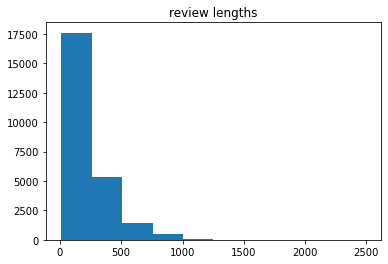

In [33]:
plt.hist([len(x) for x in X_train])
plt.title('review lengths');

We saw one way of doing this earlier, but Keras actually has a built in `pad_sequences` helper function. This handles both padding and truncating. By default padding is added to the *beginning* of a sequence.

<div class="exercise"  style="background-color:#b3e6ff">
<b>Q</b>: Why might we want to truncate? Why might we want to pad from the beginning?
</div>

In [34]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [35]:
MAX_LEN = 500
X_train = pad_sequences(X_train, maxlen=MAX_LEN)
X_test = pad_sequences(X_test, maxlen=MAX_LEN)
print('Length of first and fifth review after padding', len(X_train[0]) ,len(X_train[4]))

Length of first and fifth review after padding 500 500


<div class='exercise' id='FFNN'><b>Model 1: Naive Feed-Forward Network</b></div></br>

Let us build a single-layer feed-forward net with a hidden layer of 250 nodes. Each input would be a 500-dim vector of tokens since we padded all our sequences to size 500.

<br>
<div class="exercise"  style="background-color:#b3e6ff">
<b>Q</b>: How would you calculate the number of parameters in this network?
</div>

In [40]:
model = Sequential(name='Naive_FFNN')
model.add(Dense(250, activation='relu',input_dim=MAX_LEN))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=2)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "Naive_FFNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 251       
Total params: 125,501
Trainable params: 125,501
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
196/196 - 1s - loss: 178.4060 - accuracy: 0.4996 - val_loss: 91.7812 - val_accuracy: 0.4996
Epoch 2/10
196/196 - 0s - loss: 48.6640 - accuracy: 0.5822 - val_loss: 48.4361 - val_accuracy: 0.5026
Epoch 3/10
196/196 - 0s - loss: 17.7305 - accuracy: 0.6612 - val_loss: 31.7317 - val_accuracy: 0.5022
Epoch 4/10
196/196 - 0s - loss: 7.5028 - accuracy: 0.7264 - val_loss: 21.0285 - val_accuracy: 0.5017
Epoch 5/10
196/196 - 0s - loss: 3.9465 - accuracy: 0.7623 - val_loss: 15.6753 - val_accuracy: 0.502

<div class="exercise"  style="background-color:#b3e6ff">
<b>Q</b>: Why was the performance so poor? How could we improve our tokenization?
</div>

<div class='exercise' id='FFNN_emb'><b>Model 2: Feed-Forward Network /w Embeddings</b></div></br>
<img src='fig/wordembedding2.png' width=450px>

One can view the embedding process as a linear projection from one vector space to another. For NLP, we usually use embeddings to project the sparse one-hot encodings of words on to a lower-dimensional continuous space so that the input surface is 'dense' and possibly smooth. Thus, one can view this embedding layer process as just a transformation from $\mathbb{R}^{inp}$ to $\mathbb{R}^{emb}$

This not only reduces dimensionality but also allows semantic similarities between tokens to be captured by 'similiarities' between the embedding vectors. This was not possible with one-hot encoding as all vectors there were orthogonal to one another. 

<img src='fig/wordembedding.png' width=450px>

It is also possible to load pretrained embeddings that were learned from giant corpora. This would be an instance of transfer learning.

If you are interested in learning more, start with the astromonically impactful papers of [word2vec](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) and [GloVe](https://www.aclweb.org/anthology/D14-1162.pdf).

In Keras we use the [`Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer:
```
tf.keras.layers.Embedding(
    input_dim, output_dim, embeddings_initializer='uniform',
    embeddings_regularizer=None, activity_regularizer=None,
    embeddings_constraint=None, mask_zero=False, input_length=None, **kwargs
)
```
We'll need to specify the `input_dim` and `output_dim`. If working with sequences, as we are, you'll also need to set the `input_length`.

In [42]:
EMBED_DIM = 100

model = Sequential(name='FFNN_EMBED')
model.add(Embedding(MAX_VOCAB, EMBED_DIM, input_length=MAX_LEN))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128, verbose=2)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "FFNN_EMBED"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 250)               12500250  
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 251       
Total params: 13,500,501
Trainable params: 13,500,501
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
196/196 - 6s - loss: 0.6433 - accuracy: 0.6078 - val_loss: 0.3630 - val_accuracy: 0.8497
Epoch 2/2
196/196 - 6s - loss: 0.2349 - accuracy: 0.9025 - val_loss: 0.2977 - val_accuracy: 0.8747
Accuracy: 87.47%


<div class='exercise' id='1D_CNN'><b>Model 3: 1-Dimensional Convolutional Network</b></div></br>
<img src='fig/1D-CNN.png'>

Text can be thought of as 1-dimensional sequence (a single, long vector) and we can apply 1D Convolutions over a set of word embeddings.<br>

More information on convolutions on text data can be found on [this blog](http://debajyotidatta.github.io/nlp/deep/learning/word-embeddings/2016/11/27/Understanding-Convolutions-In-Text/). If you want to learn more, read this [published and well-cited paper](https://www.aclweb.org/anthology/I17-1026.pdf) from Eleni's friend, Byron Wallace.

<div class="exercise"  style="background-color:#b3e6ff">
<b>Q</b>: Why do we use Conv1D if our input, a sequence of word embeddings, is 2D?
</div>

In [43]:
model = Sequential(name='1D_CNN')
model.add(Embedding(MAX_VOCAB, EMBED_DIM, input_length=MAX_LEN))
model.add(Conv1D(filters=200, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, epochs=2, batch_size=128)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "1D_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 200)          60200     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 250, 200)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 250)               12500250  
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 251       
Total params: 13,560,701
Trainable params: 13,560,701
Non-trainable params: 0
________________________________________________

<div class='exercise' id='rnn_model'><b>Model 4: Simple RNN</b></div></br>
<img src='fig/simplernn.png' width=300px>

At a high-level, an RNN is similar to a feed-forward neural network (FFNN) in that there is an input layer, a hidden layer, and an output layer. The input layer is fully connected to the hidden layer, and the hidden layer is fully connected to the output layer. However, the crux of what makes it a **recurrent** neural network is that the hidden layer for a given time _t_ is not only based on the input layer at time _t_ but also the hidden layer from time _t-1_.

Here's a popular blog post on [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

In Keras, the vanilla RNN unit is implemented the`SimpleRNN` layer:
```
tf.keras.layers.SimpleRNN(
    units, activation='tanh', use_bias=True,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros', kernel_regularizer=None,
    recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    kernel_constraint=None, recurrent_constraint=None, bias_constraint=None,
    dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False,
    go_backwards=False, stateful=False, unroll=False, **kwargs
)
```
As you can see, recurrent layers in Keras take many arguments. We only need to be concerned with `units`, which specifies the size of the hidden state, and `return_sequences`, which will be discussed shortly. For the moment is it fine to leave this set to the default of `False`.

Due to the limitations of the vanilla RNN unit (more on that next) it tends not to be used much in practice. For this reason it seems that the Keras developers neglected to implement GPU acceleration for this layer! Notice how much slower the trainig is even for a network with far fewer parameters.

In [45]:
model = Sequential(name='SimpleRNN')
model.add(Embedding(MAX_VOCAB, EMBED_DIM, input_length=MAX_LEN))
model.add(SimpleRNN(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, epochs=3, batch_size=128)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "SimpleRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100)               20100     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 1,020,201
Trainable params: 1,020,201
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
196/196 [==============================] - 53s 267ms/step - loss: 0.6720 - accuracy: 0.5660
Epoch 2/3
196/196 [==============================] - 52s 266ms/step - loss: 0.5283 - accuracy: 0.7444
Epoch 3/3
196/196 [==============================] - 52s 265ms/step - loss: 0.3406 - accuracy: 0.8588
Accuracy: 83.13%


<div class='exercise' id='rnn_model'><b>Vanishing/Exploding Gradients</b></div></br>

<img src = "fig/backprop.png" width=500px>
<br>

We need to backpropogate through every time step to calculate the gradients used for our weight updates.

This requires the use of the chain rule which amounts to repeated multiplications.

This can cause two types of problems. First, this product can quickly 'explode,' becoming large, causing destructive updates to the model and numerical overflow. One hack to solve this problem is to **clip** the gradient at some threshold.

Alternatively, the gradient can 'vanish,' getting smaller and smaller as the gradient moves backwards in time. Gradient clipping will not help us here. If we can't propogate gradients suffuciently far back in time then our network will be unable to learn long temporal dependencies. This problem motivates the architecture of the GRU and LSTM units as substitutes for the 'vanilla' RNN.

For a more detailed look at the vanishing/exploding gradient problem, please see [Marios's excellent Advanced Section](https://edstem.org/us/courses/3773/lessons/11753/slides/56629). 

<div class='exercise' id='rnn_model'><b>Model 5: GRU</b></div></br>
<img src='fig/gru.png' width=800px>

$X_{t}$: input<br>
$U$, $V$, and $\beta$: parameter matrices and vector<br>
$\tilde{h_t}$: candidate activation vector<br>
$h_{t}$: output vector<br>
$R_t$: reset gate<br>
$Z_t$: update gate<br>

The gates of the GRU allow for the gradients to flow more freely to previous time steps, helping to mitigate the vanishing gradient problem.

In Keras, the [`GRU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) layer is used in exactly the same way as the `SimpleRNN` layer. 
```
tf.keras.layers.GRU(
    units, activation='tanh', recurrent_activation='sigmoid',
    use_bias=True, kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros', kernel_regularizer=None,
    recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    kernel_constraint=None, recurrent_constraint=None, bias_constraint=None,
    dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False,
    go_backwards=False, stateful=False, unroll=False, time_major=False,
    reset_after=True, **kwargs
)
```

Here we just swap it in to the previous architecture. Note how much faster it trains with GPU excelleration than the simple RNN!

In [48]:
model = Sequential(name='GRU')
model.add(Embedding(MAX_VOCAB, EMBED_DIM, input_length=MAX_LEN))
model.add(GRU(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, epochs=3, batch_size=64)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 101       
Total params: 1,060,701
Trainable params: 1,060,701
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
391/391 [==============================] - 13s 30ms/step - loss: 0.5626 - accuracy: 0.6781
Epoch 2/3
391/391 [==============================] - 12s 30ms/step - loss: 0.2510 - accuracy: 0.9011
Epoch 3/3
391/391 [==============================] - 12s 30ms/step - loss: 0.1757 - accuracy: 0.9349
Accuracy: 88.02%


<div class='exercise' id='rnn_model'><b>Model 6: LSTM</b></div></br>
<img src='fig/lstm.png' width=600px>

The LSTM lacks the GRU's 'short cut' connection (see GRU's $h_t$ above).

The LSTM also has a distinct 'cell state' in addition to the hidden state. 

Futher reading: 
- [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [LSTM: A Search Space Odyssey](https://arxiv.org/abs/1503.04069)
- [An Empirical Exploration of Recurrent Network Architectures](http://proceedings.mlr.press/v37/jozefowicz15.pdf)

Again, Kera's [`LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) works like all the other recurrent layers.
```
tf.keras.layers.LSTM(
    units, activation='tanh', recurrent_activation='sigmoid',
    use_bias=True, kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros', unit_forget_bias=True,
    kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None,
    activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None,
    bias_constraint=None, dropout=0.0, recurrent_dropout=0.0,
    return_sequences=False, return_state=False, go_backwards=False, stateful=False,
    time_major=False, unroll=False, **kwargs
)
```


In [47]:
model = Sequential(name='LSTM')
model.add(Embedding(MAX_VOCAB, EMBED_DIM, input_length=MAX_LEN))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, epochs=3, batch_size=64)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
391/391 [==============================] - 14s 33ms/step - loss: 0.5209 - accuracy: 0.7265
Epoch 2/3
391/391 [==============================] - 13s 33ms/step - loss: 0.3275 - accuracy: 0.8671
Epoch 3/3
391/391 [==============================] - 13s 33ms/step - loss: 0.2021 - accuracy: 0.9268
Accuracy: 86.39%


<div class='exercise' id='bidir'><b>BiDirectional Layer</b></div></br>
<img src='fig/birnn1.png' width=600px>

We may want our model to learn dependencies in either direction. A **BiDirectional RNN** consists of two separate recurrent units. One processing the sequence from left to right, the other processes that same sequence but in reverse, from right to left. The output of the two units are then merged together (typically concatenated) and feed to the next layer of the network.<br>



Creating a Bidirection RNN in Keras is quite simple. We just 'wrap' a recurrent layer in the [`Bidirectional`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) layer. The default behavior is to concatenate the output from each direction.

```
tf.keras.layers.Bidirectional(
    layer, merge_mode='concat', weights=None, backward_layer=None,
    **kwargs
)
```

Example:
```
model = Sequential()
...
model.add(Bidirectional(SimpleRNN(n_nodes))
...
```

<div class='exercise' id='deep'><b>Deep RNNs</b></div></br>
<img src='fig/deeprnn.png' width=600px>

We may want to stack RNN layers one after another. But there is a problem. A recurrent layer expects to be given a sequence as input, and yet we can see that the recurrent layer in each of our models above outputs a single vector. This is because the default behavior of Keras's recurrent layers is to suppress the output until the final time step. If we want to have two recurrent units in a row then the first will have to given an output after each time step, thus providing a sequence to the 2nd recurrent layer.

We can have our recurrent layers output at each time step setting `return_sequences=True`.<br>
Example:
```
model = Sequential()
...
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100)
...
```

<div class='exercise' id='timedist'><b>TimeDistributed Layer</b></div></br>


[`TimeDistributed`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) is a 'wrapper' that applies a layer to all time steps of an input sequence.
```
tf.keras.layers.TimeDistributed(
    layer, **kwargs
)
```
We use `TimeDistributed` when we want to input a sequence into a layer that doesn't normally expect a time dimension, such as `Dense`.

In [146]:
model = Sequential()
model.add(TimeDistributed(Dense(8), input_shape=(3, 5)))
input_array = np.random.randint(10, size=(1,3,5))
print("Shape of input : ", input_array.shape)

model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print("Shape of output : ", output_array.shape)

Shape of input :  (1, 3, 5)
Shape of output :  (1, 3, 8)


<div class='exercise' id='repeatvec'><b>RepeatVector Layer</b></div></br>


[`RepeatVector`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) repeats the vector a specified number of times. Dimension changes from <br>
(batch_size, number_of_elements)<br>
to<br>
(batch_size, number_of_repetitions, number_of_elements)

This effectively generates a sequence from a single input.

In [88]:
model = Sequential()
model.add(Dense(2, input_dim=1))
model.add(RepeatVector(3))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 2)                 4         
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 3, 2)              0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


<div class='exercise' id='cnn_rnn'><b>Model 7: CNN + RNN</b></div></br>

CNNs are good at learning spatial features, and sentences can be thought of as 1-D spatial vectors (dimensionality is determined by the number of words in the sentence). We can then take the features learned by the CNN (after a maxpooling layer) and feed them into an RNN! We expect the CNN to be able to pick out invariant features across the 1-D spatial structure (i.e., sentence) that characterize good and bad sentiment. This learned spatial features may then be learned as sequences by a reccurent layer. The classification step is then performed by a final dense layer.

<div class="exercise"  style="background-color:#F5E4C3">
    <b>Exercise:</b> Build a CNN + Deep, BiDirectional GRU Model
</div>

Let's put together everything we've learned so far.<br>
Create a network with:
- word embeddings in a 100-dimensional space
- conv layer with 32 filters, 3x3 kernels, 'same' padding, and ReLU activate
- 2x2 max pooling
- 2 bidirectional GRU layers, each with 50 units *per direction*
- dense output layer for binary classification

In [70]:
model = Sequential(name='CNN_GRU')
# your code here


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, epochs=3, batch_size=64)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

What is the *worst* movie review in the test set according to your model? 🍅

In [72]:
preds = model.predict_proba(X_test)
worst_review = X_test[preds.argmin()]
show_review(worst_review)

What is the *best* movie review in the test set according to your model? 🏆

In [ ]:
best_review = X_test[preds.argmax()]
show_review(best_review)

<div class="exercise"  style="background-color:#F5E4C3">
    <b>End of Exercise:</b> Please return to the main room
</div>

## Heavy Metal Lyric Generator

<img src='fig/many2manyNN.png' width=400px>

Here we'll design an RNN to generate song lyrics character by character!

The model will take in a sequences of 40 character 'windows' of text and predict the most probable next character. This new character is then appended to the original sequence, the first character is dropped, and this new sequene is fed back into the model. We can repeat this process for as long as we like to generate output of arbitrary length.

In [89]:
metal_df = pd.read_csv('data/metal_lyrics_PG.csv')

In [90]:
metal_df.shape

(4785, 4)

How to we know these are heavy metal lyrics?

In [91]:
metal_df[metal_df.lyrics.str.contains('elves')]

song  year             artist  \
116        vinvm-sabbati  2001           behemoth   
197         gaya-s-dream  1993      the-gathering   
202          generations  2013  answer-with-metal   
250      dark-of-the-sun  2006         arch-enemy   
258     shadows-and-dust  2006         arch-enemy   
...                  ...   ...                ...   
4589               scorn  2006         allegiance   
4600   armies-of-valinor  2007          galadriel   
4609      new-priesthood  2006         dark-angel   
4704      ride-for-glory  2007         dragonland   
4782  principle-of-speed  2007            drifter   

                                                 lyrics  
116   waters running down\nby the silver moon rays\n...  
197   open the gates of the past\nwith the key to ou...  
202   look around, the air is full with fear and we ...  
250   like insects of the night, we are drawn into t...  
258   at the mercy of our conscience\nconfined withi...  
...                                                 ...  
4589  likes rats we strip the earth\nrampant animals...  
4600  into the battle we ride again\nagainst the dar...  
4609  history's shown you that answers can't be foun...  
4704  \n"we yearn for the battle and the glory...but...  
4782  i made an experience\nit just happens once in ...  

[107 rows x 4 columns]

Ok, I'm convinced.

In [92]:
n_samples = 1000
lyrics_sample = metal_df.sample(n=n_samples, random_state=109).lyrics.values

In [93]:
raw_text = ' \n '.join(lyrics_sample)
# remove bad chars
raw_text = re.sub(r"[^\s\w']", "", raw_text)

chars = set(sorted(raw_text))
char2idx = dict((c,i) for i, c in enumerate(chars))
idx2char = dict((i, c) for i, c in enumerate(chars))

n_chars = len(raw_text)
n_vocab = len(chars)

print(f'Sample Corpus Length: {len(raw_text)}')

Sample Corpus Length: 720944


<div class='exercise' id='pairs'><b>Creating Input/Target Pairs</b></div></br>

We need to slice up our lyric data to create input and target pairs that can be to our model for its supervised prediction task. Each input with be a sequence of `seq_len` characters. This can be though of as a sliding window across the concatenated lyric data. The response is the character after the end of that window in the training data.

In [94]:
# prepare the dataset of input to output pairs encoded as integers
seq_len = 40
seqs = []
targets = []
for i in range(0, n_chars - seq_len):
    seq = raw_text[i:i + seq_len]
    target = raw_text[i + seq_len]
    seqs.append([char2idx[char] for char in seq])
    targets.append(char2idx[target])
n_seqs = len(seqs)
print("Total Char Sequences: ", n_seqs)

Total Char Sequences:  720904


We can create a one-hot encoding by indexing into an `n_vocab` sized identity matrix using the character index values.

In [95]:
X = np.reshape(seqs, (-1, seq_len))
eye = np.eye(n_vocab)
X = eye[seqs]
y = eye[targets]

In [96]:
X.shape, y.shape

((720904, 40, 29), (720904, 29))

In [97]:
# remove some large variables from memory
del metal_df
del lyrics_sample
del seqs

<div class='exercise' id='lambdacall'><b>LambdaCallback</b></div></br>

The loss score is usually not the best way to judge if our language model is learning to generate 'quality' test. It would be better if we could periodically see examples of the kind of text it can generate as it trains so we can judge for ourselves.

The `LambdaCallback` allows us to execute arbitary functions at different points in the training process and why they are useful when evaluating generative models. We'll use it to generate some sample text at the end of every other epoch.

In [98]:
from tensorflow.keras.callbacks import LambdaCallback

In [99]:
def on_epoch_end(epoch, _):
    # only triggers on every 2nd epoch
    if((epoch + 1) % 2 == 0):
        # select a random seed sequence
        start = np.random.randint(0, len(X)-1)
        seq = X[start]
        seed = ''.join([idx2char[np.argmax(x)] for x in seq])

        print(f"---Seed: \"{repr(seed)}\"---")
        print(f"{seed}", end='')
        # generate characters
        for i in range(200):
            x = seq.reshape(1, seq_len, -1)
            pred = model.predict(x, verbose=0)[0]
            # sampling gives us more 'serendipity' than argmax
#             index = np.argmax(pred)
            index = np.random.choice(n_vocab, p=pred)
            result = idx2char[index]
            sys.stdout.write(result)
            # shift sequence over
            seq[:-1] = seq[1:]
            seq[-1] = eye[index]
        print()
        
generate_text = LambdaCallback(on_epoch_end=on_epoch_end)

We then add the `LambdaCallback` to the `callbacks` list along with `ModelCheckpoint` and `EarlyStopping` to be passed to the `fit()` method at train time.

In [100]:
# define the checkpoint
model_name = 'metal-char'
filepath=f'models/{model_name}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1,
                             save_weights_only=False,
                             save_best_only=True, mode='min')
es = EarlyStopping(monitor='loss', patience=3, verbose=0,
                   mode='auto',restore_best_weights=True)
callbacks_list = [checkpoint, generate_text, es]

<div class="exercise"  style="background-color:#F5E4C3">
    <b>Exercise:</b> Build a Character Based Lyric Generator
</div>

**Architecture**
- Bidirection LSTM with a hidden dimension of 128 *in each direction*
- BatchNormalization to speed up training (Don't tell Pavlos!)
- Dense output layer to predict the next character

In [11]:
# your code here


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

In [ ]:
EPOCHS = 8
model.fit(X, y, epochs=EPOCHS, batch_size=128, callbacks=callbacks_list)

<div class="exercise"  style="background-color:#F5E4C3">
    <b>End of Exercise:</b> Please return to the main room
</div>

In [20]:
model = load_model(f'models/{model_name}.hdf5')

With some helper functions we can generate text from an arbitrary seed string.

In [16]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def gen_text_char(seq, temperature=0.3):
    print("Seed:")
    print("\"", ''.join([idx2char[np.argmax(x)] for x in seq]), "\"", end='')
    # generate characters
    for i in range(1000):
        x = seq.reshape(1, seq_len, -1)
        pred = model.predict(x, verbose=0)[0]
        index = sample(pred, temperature)
#             index = np.argmax(pred)
        result = idx2char[index]
        sys.stdout.write(result)
        # shift sequence over
        seq[:-1] = seq[1:]
        seq[-1] = eye[index]
    print()
    
    
def text_from_seed(s, temperature=0.3):
    s = s.lower()
    s = re.sub(r"[^\s\w']", "", s)
    char2idx = {c: i for i, c in idx2char.items()}
    seq = [char2idx[c] for c in s]
    if len(seq) < seq_len:
        print(f'Seed must be at least {seq_len} characters long!')
    seq = seq[:seq_len] 
    x = np.copy(np.array(seq))
    x = eye[x]
    gen_text_char(x, temperature)

Set a seed string and see where your model takes it.

In [ ]:
seed = "Sunshine, lollipops and rainbows\nEverything that's wonderful is what I feel when we're together "
text_from_seed(seed)

<div class="exercise"  style="background-color:#b3e6ff">
<b>Q</b>: How might you improve upon this simple model architecture?
</div>

<a id='#math'></a>
## Arithmetic with an RNN
<img src="fig/manytomanyMN.png" width="400">


*Thanks go to Eleni for this code example.*

In this exercise, we are going to teach addition to our model. Given two numbers (<999), the model outputs their sum (<9999). The input is provided as a string '231+432' and the model will provide its output as ' 663' (Here the empty space is the padding character). We are not going to use any external dataset and are going to construct our own dataset for this exercise.

The exercise we attempt to do effectively "translates" a sequence of characters '231+432' to another sequence of characters ' 663' and hence, this class of models are called sequence-to-sequence models (aka seq2seq). Such architectures have profound applications in several real-life tasks such as machine translation, summarization, image captioning etc.

To be clear, sequence-to-sequence (aka seq2seq) models take as input a sequence of length N and return a sequence of length M, where N and M may or may not differ, and every single observation/input may be of different values, too. For example, machine translation concerns converting text from one natural language to another (e.g., translating English to French). Google Translate is an example, and their system is a seq2seq model. The input (e.g., an English sentence) can be of any length, and the output (e.g., a French sentence) may be of any length.

**Background knowledge:** The earliest and most simple seq2seq model works by having one RNN for the input, just like we've always done, and we refer to it as being an "encoder." The final hidden state of the encoder RNN is fed as input to another RNN that we refer to as the "decoder." The job of the decoder is to generate each token, one word at a time. This may seem really limiting, as it relies on the encoder encapsulating the entire input sequence with just 1 hidden layer. It seems unrealistic that we could encode an entire meaning of a sentence with just one hidden layer. Yet, results even in this simplistic manner can be quite impressive. In fact, these early results were compelling enough that these models immediately replaced the decades of earlier machine translation work.

In [134]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, RepeatVector, TimeDistributed

#### data generation and preprocessing

We can simply generate all the training data we need.

In [141]:
class CharacterTable(object):
    def __init__(self, chars):        
        self.chars = sorted(set(chars))
        self.char_indices = {c: i for i, c in enumerate(self.chars)}
        self.indices_char = {i: c for i, c in enumerate(self.chars)}

    # converts a String of characters into a one-hot embedding/vector
    def encode(self, C, num_rows):        
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    # converts a one-hot embedding/vector into a String of characters
    def decode(self, x, calc_argmax=True):        
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

In [142]:
TRAINING_SIZE = 50000
DIGITS = 3
MAXOUTPUTLEN = DIGITS + 1
MAXLEN = DIGITS + 1 + DIGITS

chars = '0123456789+ '
ctable = CharacterTable(chars)

In [143]:
def return_random_digit():
      return np.random.choice(list('0123456789'))  

# generate a new number of length `DIGITS`
def generate_number():
    num_digits = np.random.randint(1, DIGITS + 1)  
    return int(''.join( return_random_digit()
                      for i in range(num_digits)))

# generate `TRAINING_SIZE` # of pairs of random numbers
def data_generate(num_examples):
    questions = []
    answers = []
    seen = set()
    print('Generating data...')
    while len(questions) < TRAINING_SIZE:      
        a, b = generate_number(), generate_number()

        # don't allow duplicates; this is good practice for training,
        # as we will minimize memorizing seen examples
        key = tuple(sorted((a, b)))
        if key in seen:
            continue
        seen.add(key)

        # pad the data with spaces so that the length is always MAXLEN.
        q = '{}+{}'.format(a, b)
        query = q + ' ' * (MAXLEN - len(q))
        ans = str(a + b)

        # answers can be of maximum size DIGITS + 1.
        ans += ' ' * (MAXOUTPUTLEN - len(ans))
        questions.append(query)
        answers.append(ans)
    print('Total addition questions:', len(questions))
    return questions, answers

def encode_examples(questions, answers):
    x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
    y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
    for i, sentence in enumerate(questions):
        x[i] = ctable.encode(sentence, MAXLEN)
    for i, sentence in enumerate(answers):
        y[i] = ctable.encode(sentence, DIGITS + 1)

    indices = np.arange(len(y))
    np.random.shuffle(indices)
    return x[indices],y[indices]

In [144]:
q,a = data_generate(TRAINING_SIZE)
x,y = encode_examples(q,a)

# divides our data into training and validation
split_at = len(x) - len(x) // 10
x_train, x_val, y_train, y_val = x[:split_at], x[split_at:],y[:split_at],y[split_at:]

print('Training Data shape:')
print('X : ', x_train.shape)
print('Y : ', y_train.shape)

print('Sample Question(in encoded form) : ', x_train[0], y_train[0])
print('Sample Question(in decoded form) : ', ctable.decode(x_train[0]),'Sample Output : ', ctable.decode(y_train[0]))

Generating data...
Total addition questions: 50000
Training Data shape:
X :  (45000, 7, 12)
Y :  (45000, 4, 12)
Sample Question(in encoded form) :  [[False False False False False False False  True False False False False]
 [False False False False False False False False False False False  True]
 [False False  True False False False False False False False False False]
 [False  True False False False False False False False False False False]
 [False False False False False False False False  True False False False]
 [False False False False False False False False False False  True False]
 [ True False False False False False False False False False False False]] [[False False False False False False False False  True False False False]
 [False False False False False False False  True False False False False]
 [False False False False False False False False False False  True False]
 [ True False False False False False False False False False False False]]
Sample Question(in decode

In [145]:
x_train

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False,  True],
        [False, False,  True, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False,  True, False],
        [ True, False, False, ..., False, False, False]],

       [[False, False, False, ..., False,  True, False],
        [False, False, False, ...,  True, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False,  True, False],
        [ True, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False,  True, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

<div class="exercise">
    <b></b> Build an RNN for Arithmetic
</div>

**Note:** Whenever you are initializing a LSTM in Keras, by the default the option `return_sequences = False`. This means that at the end of the step the next component will only get to see the final hidden layer's values. On the other hand, if you set `return_sequences = True`, the LSTM component will return the hidden layer at each time step. It means that the next component should be able to consume inputs in that form. 

Think how this statement is relevant in terms of this model architecture and the TimeDistributed module we just learned.

Build an encoder and decoder both single layer 128 nodes and an appropriate dense layer as needed by the model.

In [150]:
# Hyperaparams
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

print('Build model...')
model = Sequential()

#ENCODING
model.add(LSTM(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(RepeatVector(MAXOUTPUTLEN))

#DECODING
for _ in range(LAYERS):
    # return hidden layer at each time step
    model.add(LSTM(HIDDEN_SIZE, return_sequences=True)) 

model.add(TimeDistributed(Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Build model...
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 128)               72192     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


Let's check how well our model trained.

In [151]:
for iteration in range(1, 2):
    print()  
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=20,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so
    # we can visualize errors.
    print('Finished iteration ', iteration)
    numcorrect = 0
    numtotal = 20
    
    for i in range(numtotal):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Question', q, end=' ')
        print('True', correct, end=' ')
        print('Guess', guess, end=' ')
        if guess == correct :
            print('Good job')
            numcorrect += 1
        else:
            print('Fail')
    print('The model scored ', numcorrect*100/numtotal,' % in its test.')


Epoch 1/20
352/352 [==============================] - 5s 6ms/step - loss: 2.0174 - accuracy: 0.2885 - val_loss: 1.7942 - val_accuracy: 0.3441
Epoch 2/20
352/352 [==============================] - 2s 5ms/step - loss: 1.7772 - accuracy: 0.3434 - val_loss: 1.7091 - val_accuracy: 0.3704
Epoch 3/20
352/352 [==============================] - 2s 5ms/step - loss: 1.6578 - accuracy: 0.3831 - val_loss: 1.5676 - val_accuracy: 0.4189
Epoch 4/20
352/352 [==============================] - 2s 5ms/step - loss: 1.5156 - accuracy: 0.4305 - val_loss: 1.4042 - val_accuracy: 0.4744
Epoch 5/20
352/352 [==============================] - 2s 5ms/step - loss: 1.3777 - accuracy: 0.4846 - val_loss: 1.2784 - val_accuracy: 0.5250
Epoch 6/20
352/352 [==============================] - 2s 5ms/step - loss: 1.2598 - accuracy: 0.5288 - val_loss: 1.1922 - val_accuracy: 0.5512
Epoch 7/20
352/352 [==============================] - 2s 5ms/step - loss: 1.1605 - accuracy: 0.5640 - val_loss: 1.1004 - val_accuracy: 0.5843
Epoch

**Possible Experimentation**

 * Try changing the hyperparams, use other RNNs, more layers, check if increasing the number of epochs is useful.

 * Try reversing the data from validation set and check if commutative property of addition is learned by the model.
 * Try printing the hidden layer with two inputs that are commutative and check if the hidden representations it learned are same or similar. Do we expect it to be true? If so, why? If not why? You can access the layer using an index with model.layers and layer.output will give the output of that layer.

* Try doing addition in the RNN model the same way we do by hand. Reverse the order of digits and at each time step, input two digits get an output use the hidden layer and input next two digits and so on.(units in the first time step, tens in the second time step etc.)